This first cell is added by Kaggle by default and contains some useful info/setup to be able to open the data files for the competition. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/small-talk-intent-classification-data/Small_talk_Intent.csv


This is where we open the dataset for the competition. This can be confusing at first, which is why Kaggle prints out the path for us above. In the top right of the window the data files for this competition are also listed, so that is how we know to use `train.csv`. 

In [2]:
input_data_path = '../input/small-talk-intent-classification-data/Small_talk_Intent.csv'
df = pd.read_csv(input_data_path)
df.head()


,Utterances,Intent
0,who are you?,smalltalk_agent_acquaintance
1,all about you,smalltalk_agent_acquaintance
2,what is your personality,smalltalk_agent_acquaintance
3,define yourself,smalltalk_agent_acquaintance
4,what are you,smalltalk_agent_acquaintance


Splitting the data early on to avoid data leakage is always a good idea. You can choose a different holdout percentage with the parameters `test_size` (common or typical values are 15% or 20% of your data, but can vary depending on how much data you have). 

In [3]:
# split data into train and validation sets: df_train and df_val
from sklearn.model_selection import train_test_split

X = df['Utterances'].copy()
y = df['Intent'].copy()

X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
X_train_raw.head() + "     " + y_train.head()

1801       have you been ready?     smalltalk_agent_ready
1610    are you still working on it?     smalltalk_age...
976          that is incorrect     smalltalk_dialog_wrong
1264    it's my birthday today     smalltalk_user_has_...
1765    do you want to be my best friend?     smalltal...
dtype: object

Next is the vectorization of the data. Note that the tokenization is happening inside the `fit_transform` method as well. Parameters to the `TfidfVectorizer()` constructor can also change how the vectorization is done (e.g. limit vocabularly to __x__ most frequently occuring words, remove stopwords or not, etc.). There is lots there, so checking out the documentation for [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) is not a bad idea. 

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
#import seaborn as sns
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(X_train_raw).toarray()

# an alternative is to use term frequency:
#from sklearn.feature_extraction.text import CountVectorizer
#one_hot_vectorizer = CountVectorizer(binary=True)
#X_train = one_hot_vectorizer.fit_transform(X_train_raw))

print(f"X_train.shape = {X_train.shape}")
X_val = tfidf_vectorizer.transform(X_val_raw).toarray()
print(f"X_val.shape = {X_val.shape}")
type(X_val)

X_train.shape = (2164, 638)
X_val.shape = (383, 638)


numpy.ndarray

Finally, it's time to fit a model to the data. This is the main part of the assignment is to use a model __other than RandomForest__. Fortunately, this should not be too difficult of a chance to this notebook since Scikit Learn has many, many types of classification models, and they are easily interchangeable. Besides the RandomForestClassifier, there are:
* [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
* [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)
* [ExtraTreesClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html)
* [HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html)
* [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
* [Naive Bayes Multinomial Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

and even more options. Feel free to choose another one. 

# Model 1 (Decision Tree Classifier)

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

model = DecisionTreeClassifier()
model = model.fit(X_train, y_train)

predictions_train = model.predict(X_train)

print(f"accuracy (on X_train): {accuracy_score(y_train, predictions_train):.4f}")

accuracy (on X_train): 0.9940


In [6]:
predictions_val = model.predict(X_val)
print(f"accuracy (on X_train): {accuracy_score(y_val, predictions_val):.4f}")


accuracy (on X_train): 0.7415


As we did previously, let's now check to see if there is any hyperparameter tuning that can be done to further improve the model performance. We saw that for Random Forest there will not be much difference here, but hyperparameter choices for other types of the models can cause performance to vary much more. 

In [7]:
from sklearn.metrics import log_loss

tune_model = True # can change this to False once you've chosen a hyperparam value and before Saving your notebook with Kaggle
intents = df['Intent'].unique()
# A function to create and fit a RF with a specific number of trees
def tuneModel(hyperparam_value):
    rf_model = DecisionTreeClassifier(min_samples_split=hyperparam_value)
    rf_model.fit(X_train, y_train)
    y_train_pred_prob = rf_model.predict_proba(X_train)
    y_train_pred = rf_model.predict(X_train)
    y_val_pred_prob = rf_model.predict_proba(X_val)
    y_val_pred = rf_model.predict(X_val)
    train_loss = log_loss(y_train, y_train_pred_prob, labels=intents)
    train_acc = accuracy_score(y_train, y_train_pred)
    val_loss = log_loss(y_val, y_val_pred_prob, labels=intents)
    val_acc = accuracy_score(y_val, y_val_pred)
    return (train_loss, val_loss, train_acc, val_acc)

# Possible values for the hyperparameter are in the range of 5 to 150 (by 50)
hyp_param_vals = list(range(39,43,1)) # good values for n_estimators
hyp_param_vals = [2,3] + list(range(5, 50, 10)) # good values for min_samples_split
metrics = []

if tune_model:
    for hp in hyp_param_vals:
        metrics.append(tuneModel(hp))

Plot the results of the model performance for each hyperparameter value we looked at

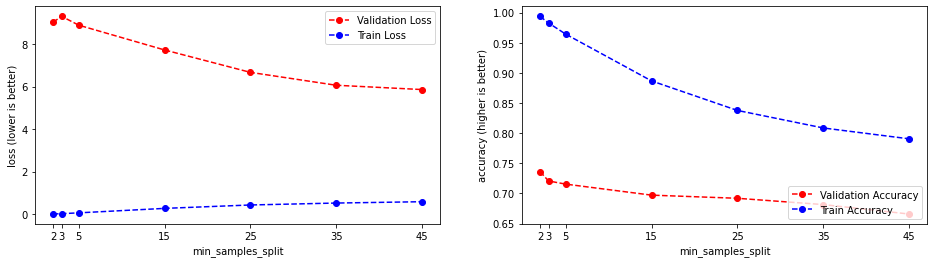

In [8]:
import matplotlib.pyplot as plt

if tune_model:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    ax1.set_xticks(hyp_param_vals)
    ax1.set(xlabel="min_samples_split", ylabel="loss (lower is better)")
    ax1.plot(hyp_param_vals, [metric[1] for metric in metrics], '--ro') # validation loss
    ax1.plot(hyp_param_vals, [metric[0] for metric in metrics], '--bo') # training loss
    ax1.legend(["Validation Loss", "Train Loss"], loc=1)

    ax2.set_xticks(hyp_param_vals)
    ax2.set(xlabel="min_samples_split", ylabel="accuracy (higher is better)")
    ax2.plot(hyp_param_vals, [metric[3] for metric in metrics], '--ro') # validation accuracy
    ax2.plot(hyp_param_vals, [metric[2] for metric in metrics], '--bo') # training accuracy
    ax2.legend(["Validation Accuracy", "Train Accuracy"], loc=4)

To be certain, let's look at the table of values and see which hyperparameter value has the lowest.

In [9]:
# a simple matrix with first row containing hyperparam values, second row containing validation loss, third row containing validation accuracy
# (this could be presented in an even nicer format using a pandas dataframe if you like)
if tune_model:
    tuning_results = np.array([hyp_param_vals, [round(metric[1],2) for metric in metrics], [round(metric[3],2) for metric in metrics]])
    print(tuning_results)

[[ 2.    3.    5.   15.   25.   35.   45.  ]
 [ 9.02  9.3   8.88  7.72  6.67  6.06  5.86]
 [ 0.74  0.72  0.72  0.7   0.69  0.68  0.67]]


In [10]:
# refit the model with the best hyperparameter value you found
model = DecisionTreeClassifier(min_samples_split=3)
model = model.fit(X_train, y_train)

# this make predictions for the test set
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_val)
predictions_test[:10]

array(['smalltalk_agent_good', 'smalltalk_agent_clever',
       'smalltalk_user_here', 'smalltalk_agent_crazy',
       'smalltalk_user_likes_agent', 'smalltalk_user_needs_advice',
       'smalltalk_agent_beautiful', 'smalltalk_confirmation_yes',
       'smalltalk_user_here', 'smalltalk_agent_busy'], dtype=object)

Now append the predictions to the `df_test` data frame as a new column and peek at some of those to see if the predictions look decent. 

In [11]:
print(f"accuracy (on X_train): {accuracy_score(y_train, predictions_train):.4f}")
print(f"accuracy (on X_val): {accuracy_score(y_val, predictions_test):.4f}")

accuracy (on X_train): 0.9829
accuracy (on X_val): 0.7467


# Model 2 (Gaussian Naive Bayes)

In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

model = GaussianNB()
model = model.fit(X_train, y_train)

predictions_train = model.predict(X_train)

print(f"accuracy (on X_train): {accuracy_score(y_train, predictions_train):.4f}")

accuracy (on X_train): 0.8688


In [13]:
predictions_val = model.predict(X_val)
print(f"accuracy (on X_train): {accuracy_score(y_val, predictions_val):.4f}")

accuracy (on X_train): 0.6658


In [14]:
from sklearn.metrics import log_loss

tune_model = True # can change this to False once you've chosen a hyperparam value and before Saving your notebook with Kaggle
intents = df['Intent'].unique()
# A function to create and fit a RF with a specific number of trees
def tuneModel(hyperparam_value):
    rf_model = GaussianNB(var_smoothing=hyperparam_value)
    rf_model.fit(X_train, y_train)
    y_train_pred_prob = rf_model.predict_proba(X_train)
    y_train_pred = rf_model.predict(X_train)
    y_val_pred_prob = rf_model.predict_proba(X_val)
    y_val_pred = rf_model.predict(X_val)
    train_loss = log_loss(y_train, y_train_pred_prob, labels=intents)
    train_acc = accuracy_score(y_train, y_train_pred)
    val_loss = log_loss(y_val, y_val_pred_prob, labels=intents)
    val_acc = accuracy_score(y_val, y_val_pred)
    return (train_loss, val_loss, train_acc, val_acc)

# Possible values for the hyperparameter are in the range of 5 to 150 (by 50)
hyp_param_vals = list(range(39,43,1)) # good values for n_estimators
hyp_param_vals = [2,3] + list(range(5, 50, 10)) # good values for min_samples_split
metrics = []

if tune_model:
    for hp in hyp_param_vals:
        metrics.append(tuneModel(hp))

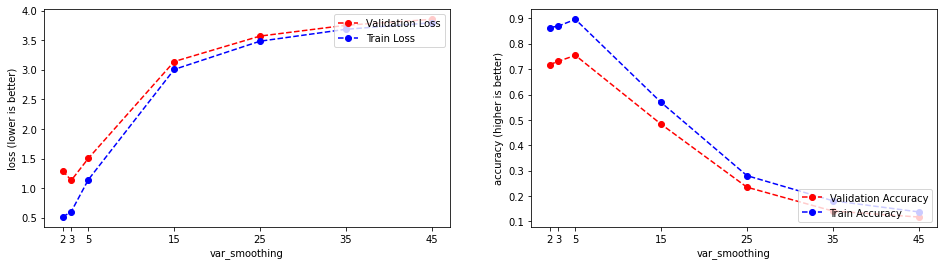

In [15]:
import matplotlib.pyplot as plt

if tune_model:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    ax1.set_xticks(hyp_param_vals)
    ax1.set(xlabel="var_smoothing", ylabel="loss (lower is better)")
    ax1.plot(hyp_param_vals, [metric[1] for metric in metrics], '--ro') # validation loss
    ax1.plot(hyp_param_vals, [metric[0] for metric in metrics], '--bo') # training loss
    ax1.legend(["Validation Loss", "Train Loss"], loc=1)

    ax2.set_xticks(hyp_param_vals)
    ax2.set(xlabel="var_smoothing", ylabel="accuracy (higher is better)")
    ax2.plot(hyp_param_vals, [metric[3] for metric in metrics], '--ro') # validation accuracy
    ax2.plot(hyp_param_vals, [metric[2] for metric in metrics], '--bo') # training accuracy
    ax2.legend(["Validation Accuracy", "Train Accuracy"], loc=4)

In [16]:
# refit the model with the best hyperparameter value you found
model = GaussianNB(var_smoothing=5)
model = model.fit(X_train, y_train)

# this make predictions for the test set
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_val)
predictions_test[:10]

array(['smalltalk_agent_bad', 'smalltalk_agent_clever',
       'smalltalk_user_here', 'smalltalk_agent_crazy',
       'smalltalk_user_likes_agent', 'smalltalk_agent_acquaintance',
       'smalltalk_user_looks_like', 'smalltalk_agent_my_friend',
       'smalltalk_user_here', 'smalltalk_agent_busy'], dtype='<U39')

In [17]:
print(f"accuracy (on X_train): {accuracy_score(y_train, predictions_train):.4f}")
print(f"accuracy (on X_val): {accuracy_score(y_val, predictions_test):.4f}")

accuracy (on X_train): 0.8965
accuracy (on X_val): 0.7546
